In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing import text, sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D, MaxPooling1D
print(tf.__version__)

2.12.0


# **Load and Explore Data**

In [ ]:
train_df = pd.read_csv('/content/drive/MyDrive/TA/train_data.csv')
test_df = pd.read_csv('/content/drive/MyDrive/TA/test_data.csv')

In [ ]:
train_df.sample(10,random_state=1)

,text,hs_class
3427,bodoh sial anak anjinggg maju setan sweater ma...,1
1653,peluh keringat jatuh 3 jam tani suara mas chol...,0
5289,kerja musuh dakwah islam bubar hati rakyat hak...,1
1924,gue benci orang gue informasi banget tanggal t...,0
5897,bravo jokowi tekan freepo hak rakyat lihat pro...,0
8164,kecewa bisu,0
2398,anak anjing kampang,1
4928,ustaz subki al bughury sih sos i dukung pilih ...,0
7667,6 tulis impi rangkum impi rakyat impi indonesi...,0
5790,ya panggil siput sipit sih xad,0


In [ ]:
x = train_df['text']
y = train_df['hs_class']

<Axes: title={'center': 'Distribution of Hate Speech Comments'}, ylabel='Frequency'>

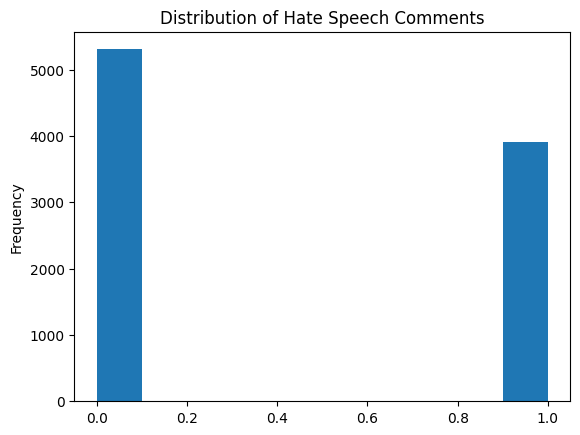

In [ ]:
# Plot frequency of toxic comments
train_df['hs_class'].plot(kind='hist',title='Distribution of Hate Speech Comments')

In [ ]:
train_df['hs_class'].value_counts()

0    5307
1    3911
Name: hs_class, dtype: int64

# **Tokenize and Pad Text Data**

In [ ]:
max_features = 20000
max_text_length = 400

In [ ]:
x_tokenizer = text.Tokenizer(max_features)
# x_tokenizer.fit_on_texts(list(x))

In [ ]:
x = [str(item) for item in x]  # Convert float values to strings
x_tokenizer.fit_on_texts(x)

In [ ]:
x_tokenized =x_tokenizer.texts_to_sequences(x)
x_train_val= sequence.pad_sequences(x_tokenized,maxlen=max_text_length)

# **Prepare Embedding Matrix with Pre-trained Fasttext Word Embeddings**

In [ ]:
import codecs
from tqdm import tqdm
embedding_dim =100
embeddings_index = {}
f = codecs.open('/content/drive/MyDrive/TA/ft_model.vec', encoding='utf-8')
for line in tqdm(f):
  values = line.rstrip().rsplit(' ')
  word = values[0]
  coefs = np.asarray(values[1:], dtype='float32')
  embeddings_index[word] = coefs
f.close()
print(f'Found {len(embeddings_index)} word vectors')

214239it [00:12, 17648.91it/s]

Found 214239 word vectors


In [ ]:
embedding_matrix= np.zeros((max_features,embedding_dim))
for word, index in x_tokenizer.word_index.items():
    if index>max_features-1:
        break
    else:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[index]= embedding_vector

# **CNN Architecture**

In [ ]:
filters= 250
kernel_size=3
hidden_dims= 250

In [ ]:
model = Sequential()
model.add(Embedding(max_features,
                    embedding_dim,
                    embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
                    trainable=False))
model.add(Dropout(0.2))
model.add(Conv1D(filters,
                 kernel_size,
                 padding='valid',
                 activation='relu'))
model.add(MaxPooling1D())
model.add(Conv1D(filters,
                 5,
                 padding='valid',
                 activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(hidden_dims, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(1, activation='sigmoid'))
#adam = optimizers.Adam(lr = 0.01)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 100)         2000000   
                                                                 
 dropout (Dropout)           (None, None, 100)         0         
                                                                 
 conv1d (Conv1D)             (None, None, 250)         75250     
                                                                 
 max_pooling1d (MaxPooling1D  (None, None, 250)        0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, None, 250)         312750    
                                                                 
 global_max_pooling1d (Globa  (None, 250)              0         
 lMaxPooling1D)                                         

# **Compile Model**

In [ ]:
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

# **Splitting Data into Training and Validation Set**

In [ ]:
x_train,x_val,y_train,y_val = train_test_split(x_train_val,y,test_size=0.15,random_state=1)

In [ ]:
batch_size= 32
epochs = 5
hist = model.fit(x_train,y_train,
          batch_size= batch_size,
          epochs=epochs,
          validation_data= (x_val,y_val)
          )

Epoch 1/5
245/245 [==============================] - 118s 475ms/step - loss: 0.1959 - accuracy: 0.9167 - val_loss: 0.1990 - val_accuracy: 0.9168
Epoch 2/5
245/245 [==============================] - 113s 461ms/step - loss: 0.1458 - accuracy: 0.9428 - val_loss: 0.1230 - val_accuracy: 0.9516
Epoch 3/5
245/245 [==============================] - 116s 471ms/step - loss: 0.1087 - accuracy: 0.9552 - val_loss: 0.1274 - val_accuracy: 0.9559
Epoch 4/5
245/245 [==============================] - 114s 467ms/step - loss: 0.0921 - accuracy: 0.9625 - val_loss: 0.2147 - val_accuracy: 0.9197
Epoch 5/5
245/245 [==============================] - 118s 483ms/step - loss: 0.0835 - accuracy: 0.9675 - val_loss: 0.1307 - val_accuracy: 0.9508


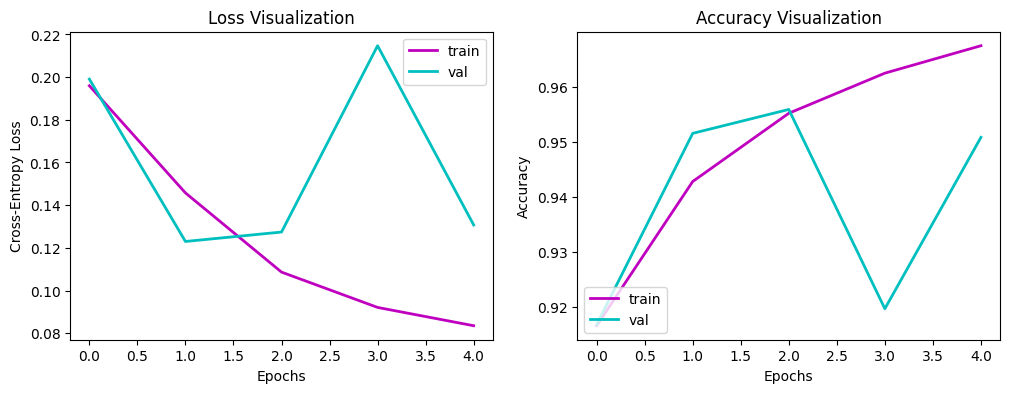

In [ ]:
#generate plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.plot(hist.history['loss'], lw=2.0, color='m', label='train')
ax1.plot(hist.history['val_loss'], lw=2.0, color='c', label='val')
ax1.set_title('Loss Visualization')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Cross-Entropy Loss')
ax1.legend(loc='upper right')

ax2.plot(hist.history['accuracy'], lw=2.0, color='m', label='train')
ax2.plot(hist.history['val_accuracy'], lw=2.0, color='c', label='val')
ax2.set_title('Accuracy Visualization')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend(loc='lower left')

plt.show()

# **Evaluate Model**

In [ ]:
test_df = pd.read_csv('/content/drive/MyDrive/TA/test_data.csv')
x_test= test_df['text'].values

In [ ]:
x_test = [str(item) for item in x_test]  # Convert float values to strings
# sebagai bagian dari prapemrosesan teks untuk tugas pembelajaran mesin, di mana input numerik diperlukan.
x_test_tokenized = x_tokenizer.texts_to_sequences(x_test) # Mengubah setiap teks menjadi bilangan urutan bil.bulat
x_testing = sequence.pad_sequences(x_test_tokenized, maxlen=max_text_length)

In [ ]:
# y_testing= model.predict(x_testing,verbose=1,batch_size=32)
# y_testing_binary = np.round(y_testing).flatten()

Extras: to view our result!

In [ ]:
# test_df['hs_class'] = [ 'not hs' if x<0.5 else 'hs' for x in y_testing]

In [ ]:
# test_df[['text','hs_class']].head(20)

# **Confusion Matrix and Classification Report**

In [ ]:
#Evaluate the model on the test data
x_test = test_df['text']
y_test = test_df['hs_class']
x_test = [str(item) for item in x_test]
x_test_tokenized = x_tokenizer.texts_to_sequences(x_test)
x_test_padded = sequence.pad_sequences(x_test_tokenized, maxlen=max_text_length)
#Predict labels for test data
y_pred = model.predict(x_testing)
y_pred_binary = np.round(y_pred).flatten()

124/124 [==============================] - 16s 131ms/step


In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred_binary)
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[1976  325]
 [ 456 1194]]


In [ ]:
# Calculate classification report
cr = classification_report(y_test, y_pred_binary)
print("Classification Report:")
print(cr)

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.86      0.83      2301
           1       0.79      0.72      0.75      1650

    accuracy                           0.80      3951
   macro avg       0.80      0.79      0.79      3951
weighted avg       0.80      0.80      0.80      3951



# **Implement Cross Validation**

In [ ]:
import numpy as np
from sklearn.model_selection import KFold

# Prepare the data for cross-validation
x_train_val = np.array(x_train_val)
y = np.array(y)

# Define the number of folds for cross-validation
k = 3

# Initialize lists to store evaluation metrics for each fold
all_scores = []
all_cm = []

# Perform k-fold cross-validation
kf = KFold(n_splits=k, shuffle=True, random_state=1)
for fold, (train_index, val_index) in enumerate(kf.split(x_train_val)):
    print(f"***FOLD {fold+1}***")

    # Split the data into training and validation sets
    x_train_fold, x_val_fold = x_train_val[train_index], x_train_val[val_index]
    y_train_fold, y_val_fold = y[train_index], y[val_index]

    # Define the model architecture
    model = Sequential()
    model.add(Embedding(max_features,
                        embedding_dim,
                        embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
                        trainable=False))
    model.add(Dropout(0.2))
    model.add(Conv1D(filters,
                     kernel_size,
                     padding='valid',
                     activation='relu'))
    model.add(MaxPooling1D())
    model.add(Conv1D(filters,
                     5,
                     padding='valid',
                     activation='relu'))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(hidden_dims, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid'))
    model.summary()
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    # Train the model
    batch_size = 32
    epochs = 5
    hist_fold = model.fit(x_train_fold, y_train_fold,
              batch_size= batch_size,
              epochs=epochs,
              validation_data= (x_val,y_val),
              verbose=1)#control display

***FOLD 1***
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 100)         2000000   
                                                                 
 dropout_2 (Dropout)         (None, None, 100)         0         
                                                                 
 conv1d_2 (Conv1D)           (None, None, 250)         75250     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, None, 250)        0         
 1D)                                                             
                                                                 
 conv1d_3 (Conv1D)           (None, None, 250)         312750    
                                                                 
 global_max_pooling1d_1 (Glo  (None, 250)              0         
 balMaxPooling1D)                        

In [ ]:
# Evaluate the model on the validation fold
scores = model.evaluate(x_val_fold, y_val_fold)
all_scores.append(scores)
# Predict labels for the validation fold
y_pred = model.predict(x_val_fold)
y_pred_binary = np.round(y_pred).flatten()
# Calculate confusion matrix for the validation fold
cm = confusion_matrix(y_val_fold, y_pred_binary)
all_cm.append(cm)

96/96 [==============================] - 12s 122ms/step


In [ ]:
# Calculate average scores and confusion matrix over all folds
avg_scores = np.mean(all_scores, axis=0)
avg_cm = np.mean(all_cm, axis=0)

# Print average scores and confusion matrix
print("Average Scores:")
print("Loss:", avg_scores[0])
print("Accuracy:", avg_scores[1])
print()
print("Average Confusion Matrix:")
print(avg_cm)

Average Scores:
Loss: 0.1342296153306961
Accuracy: 0.953125

Average Confusion Matrix:
[[1680.  109.]
 [  35. 1248.]]


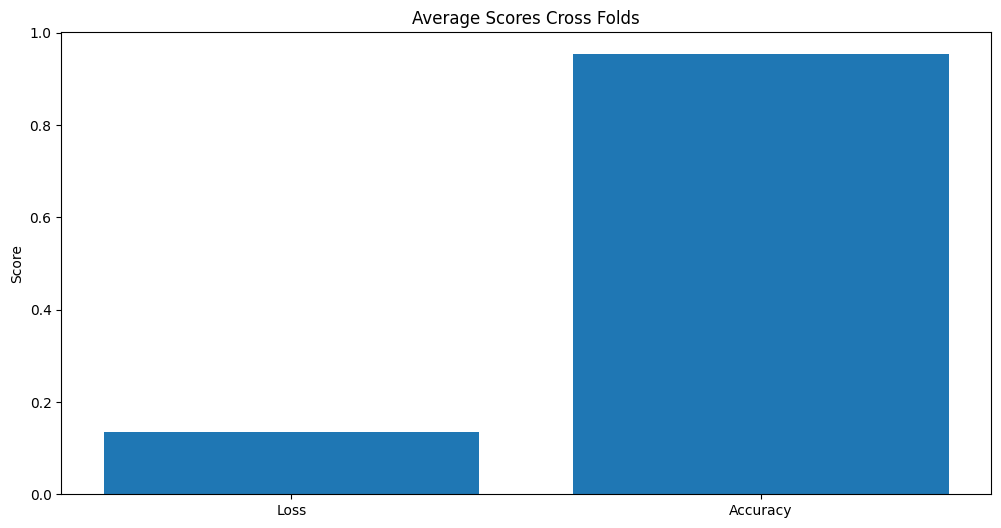

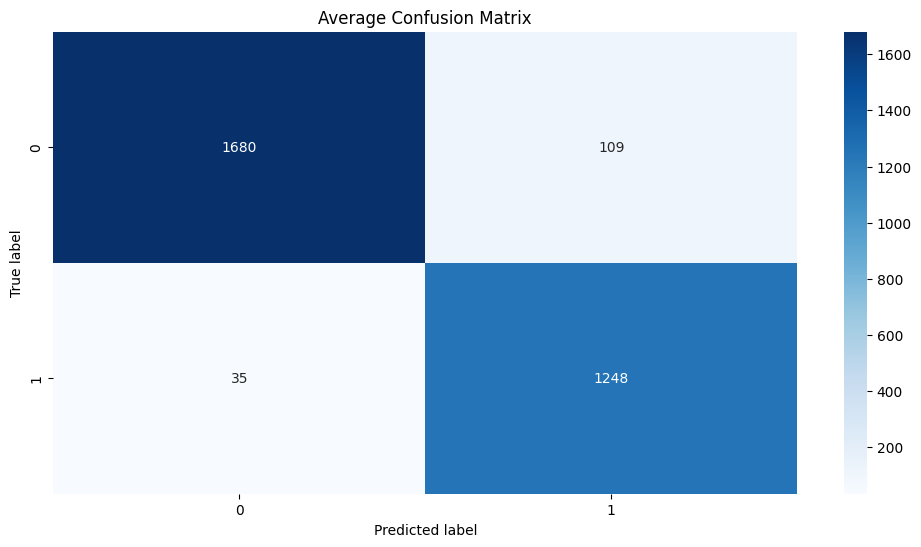

In [ ]:
import seaborn as sns

# Visualize the average scores
plt.figure(figsize=(12, 6))
plt.bar(['Loss', 'Accuracy'], avg_scores)
plt.ylabel('Score')
plt.title('Average Scores Cross Folds')
plt.show()

# Visualize the average confusion matrix
plt.figure(figsize=(12, 6,))
sns.heatmap(avg_cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Average Confusion Matrix')
plt.show()

124/124 [==============================] - 12s 99ms/step


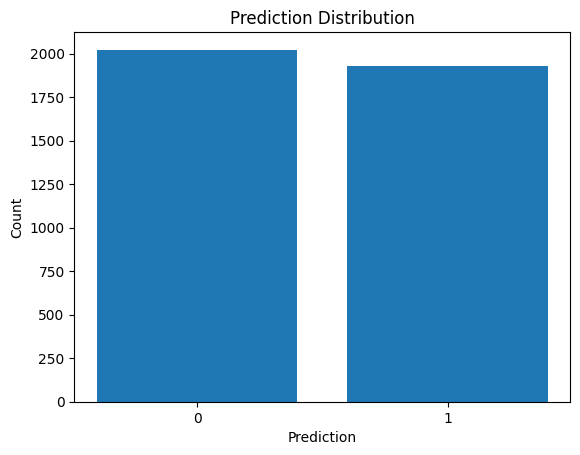

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Get predictions
predictions = model.predict(x_testing)

# Round the predictions to obtain binary values (0 or 1)
binary_predictions = np.round(predictions).flatten()

# Count the number of occurrences of each predicted class
unique, counts = np.unique(binary_predictions, return_counts=True)

# Create a bar plot
plt.bar(unique, counts)
plt.xlabel('Prediction')
plt.ylabel('Count')
plt.xticks([0, 1])
plt.title('Prediction Distribution')
plt.show()


In [ ]:
# Get predictions
predictions = model.predict(x_testing)

# Round the predictions to obtain binary values (0 or 1)
binary_predictions = np.round(predictions).flatten()

# Convert the true labels to binary values (0 or 1)
binary_labels = y_pred.flatten()

# Print predicted class and actual class for each input
for i in range(len(x_test)):
    print(f'Text: {x_test[i]}')
    print(f'Predicted Class: {int(binary_predictions[i])}')
    print(f'Actual Class: {int(binary_labels[i])}')
    print('---')

Streaming output truncated to the last 5000 lines.
Actual Class: 0
---
Text: menteri lingkung hidup hutan upaya perata ekonomi tora kawasan hutan hutan sosial
Predicted Class: 0
Actual Class: 0
---
Text: kayak monyet
Predicted Class: 1
Actual Class: 1
---
Text: 4 tulis chat
Predicted Class: 0
Actual Class: 0
---
Text: gue ngemafia main 3 acc edan
Predicted Class: 0
Actual Class: 0
---
Text: iya sih vivin tai dasar rebut laki orang alexa alda rico baj
Predicted Class: 1
Actual Class: 0
---
Text: bom bunuh teroris bunuh jihad dukung antek teroris bela
Predicted Class: 1
Actual Class: 0
---
Text: tau taplak meja rumah bentuk nya kayak
Predicted Class: 0
Actual Class: 0
---
Text: tukang hoaks basmi hoaks bunuh
Predicted Class: 1
Actual Class: 0
---
Text: giring opini presiden menang 2 periode lawan prabowo lulus 2 periode hati hati cebong agen ganda
Predicted Class: 1
Actual Class: 0
---
Text: kah komunis syiah masuk jin anu alergi islam bangkit islam moga bawa dungu periode
Predicted Clas

IndexError: ignored

In [ ]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model,show_shapes = True, dpi=100).create(prog='dot', format='svg'))